<a href="https://colab.research.google.com/github/chris-kehl/-earthquakes/blob/master/bear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.7MB/s 
     |████████████████████████████████| 1.2MB 29.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 194kB 38.6MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Setup Microsoft Bing keys used to search and scrape images from the web.

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'your azure key')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [7]:

ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [9]:
dest = 'grizzly.jpg'
download_url(ims[0], dest)



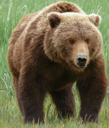

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

Setup directory and folder used to store the images. Check downloaded images for any failed downloads.

In [11]:
bear_types = 'grizzly', 'black', 'teddy', 'polar'
path = Path('bears')

In [12]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#550) [Path('bears/black/00000035.jpg'),Path('bears/black/00000063.jpg'),Path('bears/black/00000097.jpg'),Path('bears/black/00000056.jpg'),Path('bears/black/00000091.jpg'),Path('bears/black/00000033.jpg'),Path('bears/black/00000087.jpg'),Path('bears/black/00000131.jpg'),Path('bears/black/00000100.jpg'),Path('bears/black/00000004.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#4) [Path('bears/black/00000065.jpg'),Path('bears/black/00000120.jpg'),Path('bears/grizzly/00000089.jpg'),Path('bears/teddy/00000021.jpg')]

In [16]:
failed

(#4) [Path('bears/black/00000065.jpg'),Path('bears/black/00000120.jpg'),Path('bears/grizzly/00000089.jpg'),Path('bears/teddy/00000021.jpg')]

Format the downloaded data into a format that is suitable for model training. Fastai uses dataloaders.

In [22]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train, valid = add_props(lambda i,self: self[i])

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


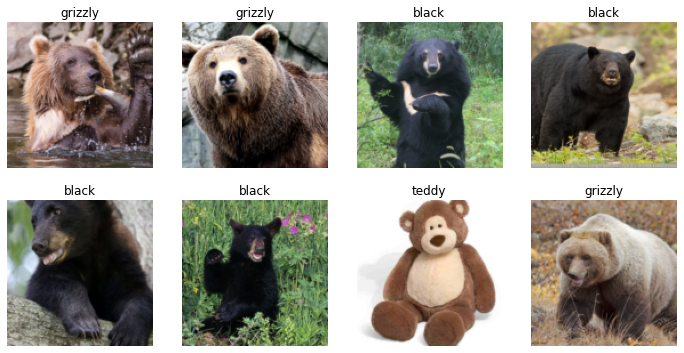

In [25]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


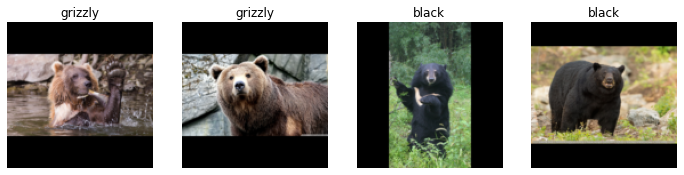

In [26]:
bears = bears.new(item_tfms=Resize(128,
ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

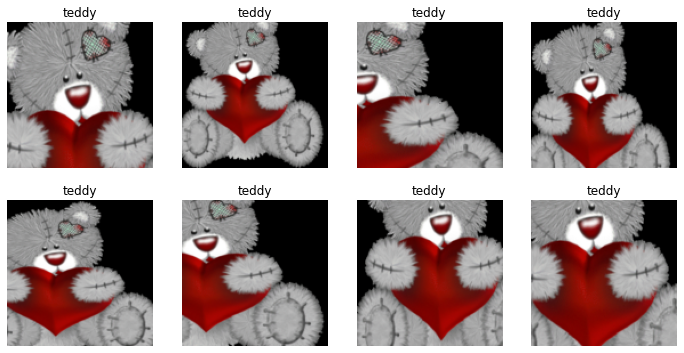

In [29]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Data Augmentation